# 4 CIFAR10REC
__Cifar10 Visual Recognition Challenge__

In this notebook, you will again deal with [PyTorch](https://pytorch.org/), a popular deep learning framework for scientific research. Most of the code is already written, including a deep neural network model.
However, the performance of said model is subpar. It is your task to complete the indicated functions and cells, so that you can train the model. Further, you should change and tweak the model as well as hyperparameters to create a well performing model. You can aim for accuracies in the 50ies!

Experiment around with architecture choices and different hyperparamters. The lecture slides and PyTorch documentation give you a good overview of what is possible. Keep in mind, though, that blindly copy-pasting code from other sources without proper referencing and consent is plagiarism!

The quality of your model is evaluated on the test dataset. Continously optimizing your model according to the performance on the test data set is bad scientific practice. Ideally, the evaluation on the test data should happen  just once, when you are confident that you have trained your model to the best of your knowledge. While tweaking your model, you may evaluate its quality on a validation set of the data.

You are not allowed to change arbitrary code of the notebook. Instead, functions, variables etc. which you can change, will be indicated explicitely (see __Task__ keyword).
Please leave the seeds intact!

## 4.1 Installing PyTorch

In [22]:
!pip install torch torchvision tqdm

Defaulting to user installation because normal site-packages is not writeable


In [23]:
import torch
import torch.nn as nn
import torchvision

torch.manual_seed(42)
import matplotlib.pyplot as plt
import numpy as np
import random

## 4.2 Obtaining the Dataset
We are going to use the [Cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which is a more difficult alternative to well-known [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

In [24]:
# if, for some reason, you are not using a UNIX-based operabting system, \
# you might need to adjust the path arguments
trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

label_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

Files already downloaded and verified
Files already downloaded and verified


### Task 4.2.1 Inspecting a Sample from the Data
Choose a random sample from the training data, and:
- print its shape
- visualize the sample with an appropriate plot
- print its label (or title the plot appropriately)

torch.Size([3, 32, 32])


Text(0.5, 1.0, "Random sample (label: 'ship)'")

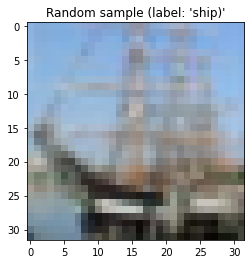

In [25]:
idx = random.randint(0, len(trainset) - 1)
sample = trainset[idx][0]
print(sample.shape)

# idk if this is the proper way but it works
img = torch.transpose(torch.transpose(sample, 0, 2), 0, 1)
plt.imshow(img)

plt.title(f"Random sample (label: '{label_names[trainset[idx][1]]})'")

### Task 4.2.2 Validation Split 

__YOU MAY EDIT PARTS OF THE NEXT CELL__

In order to judge the quality of your training efforts, you might want to validate your model on a part of the data it has not seen yet. However, we cannot do that repeatedly on the test dataset.

Therefore, we can split off some data from our training data. Make a decision about the validation split! The more data you take off from the training set, the more accurate will your evaluation be. The less data you leave for actual training, the worse your model performance will be.

_Hint: Currently, the validation size is 100, which seems a bit small._

In [26]:
# set validation_size to be 5% of trainingset
validation_size = round(len(trainset) * 0.05)  # set the size of your validation set
trainset, valset = torch.utils.data.random_split(
    trainset,
    [len(trainset) - validation_size, validation_size],
    generator=torch.Generator().manual_seed(1337),
)

### 4.2.3 Torch DataLoader
Now we can hand over our three datasets to the DataLoader class which brings a lot of convience to the training procedure. It can batch and shuffle our data.

The batch size is set to 32 which is an appropriate value. You may change the batch_size for the trainloader, if you want.

Shuffling is not needed for validation and testing because we are only running through the data once, anyway.

In [27]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)

## Task 4.3 Building a Model
__YOU MAY EDIT PARTS OF THE NEXT CELL__

We are going to use [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to build a multi-layer perceptron (not a CNN!).
You can simply supply [layers and building blocks](https://pytorch.org/docs/stable/nn.html) as arguments to create your network architecture in a sequential way, i.e. the data will flow through the network in the order they are listed as arguments.

Useful modules for MLPs are:
- [Linear Layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
- [Activation Functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)
- [Dropout Layers](https://pytorch.org/docs/stable/nn.html#dropout-layers)
- [Batch Normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html?highlight=batchnormalization)

The input to the model is an image, which has to be flattened to a vector, so that it is represented as suitable input for the MLP.

The output must be a vector of size 10 (according to our labels/classes).

You are supplied with a model that does not perform too well. You are free to build a MLP of your choice. Be aware that larger networks will take more time to train!

Tips for experimentation:
- Layer sizes
- Number of layers
- Activation functions
- Dropout
- Batch Normalization

_Hint: What is known in PyTorch as a linear layer refers to a fully connected or dense layer._

In [28]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 512),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(512, 64),
    nn.Tanh(),
    nn.Linear(64, 10),
)

## 4.4 Training the Model
Now that we have a model architecture, we will need to specify a training procedure.

### Task 4.4.1 Choosing Hyperparameters
__YOU MAY EDIT PARTS OF THE NEXT CELL__

A few parameters for the training process need to be predefined and are not learned via gradient descent or backprop. We refere to these as hyperparameters.

In the following, you are presented with four of those that shape the training process and can have great influence on the trained models performance.

The machine-learning practictioner who set up this notebook apparently did not pay full attention to the lecture and literature. Although all lead to a working model, the values of some are not chosen to the best of our knowledge.

In [29]:
learning_rate = 0.05
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs = 150

### 4.4.2 The Training Function
The function `train` trains your model for one epoch and keeps track of the correct/incorrect predictions. It takes a model, a dataloader, and optimizer and a loss function, trains the model for one epoch and returns the mean loss over the epoch as well as the accuracy.

In [30]:
def train(model, dataloader, optimizer, loss):
    epoch_loss = []
    model.train()
    correct = 0
    total = 0
    for img, lbl in dataloader:
        optimizer.zero_grad()
        out = model(img)
        logits, indices = torch.max(out, 1)
        correct += torch.sum(indices == lbl).item()
        total += len(lbl)
        batch_loss = loss(out, lbl)
        batch_loss.backward()
        optimizer.step()
        epoch_loss.append(batch_loss.item())

    return np.mean(epoch_loss), correct / total

### 4.4.3 The Validation Function
The function `evaluate` evaluates the model on specified data. It takes a model and a dataloader and returns the accuracy.

In [31]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for img, lbl in dataloader:
        out = model(img)
        logits, indices = torch.max(out, 1)
        correct += torch.sum(indices == lbl).item()
        total += len(lbl)
    return correct / total

### Task 4.4.4 The Training Loop
Write the training loop for your model:
- Call the `train` function for your model for the specified number of epochs. 
- For each epoch, keep track of the loss and the training accuracy.
- You should also keep track of the validation accuracy, to judge the models actual performance on unseen data.
- Store all values for visualization purposes later on.

Run your training loop! Depending on the size of your network architecture and the number of epochs, this might take a few minutes.

In [32]:
from tqdm import tqdm

loss_trk = []
accuracy_trk = []

pr_b = tqdm(range(epochs))

for e_idx in pr_b:
  pr_b.set_description(f"Loss: {loss_trk[-1]):.4f}")
  (l,a) = train(model,testloader,optimizer,loss)
  loss_trk.append(l)
  accuracy_trk.append(a)

100%|██████████| 150/150 [12:14<00:00,  4.90s/it]


### Task 4.4.5 Visualize the Training
Visually inspecting the models behavior over the training period can give insights on problems and performance issues.

Plot (A) the training loss and the training accuracy and (B) the validation accuracy over the epochs.

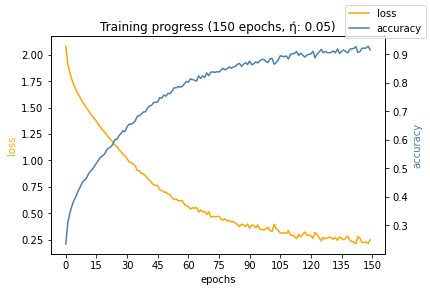

In [40]:
(fig, ax) = plt.subplots()


ax.plot(loss_trk, label="loss", color="orange")
ax.set_xlabel("epochs")
ax.set_ylabel("loss", color="orange")
ax.set_xticks([i for i in range(0, epochs + 1, epochs // 10)])

ax2 = ax.twinx()
ax2.plot(accuracy_trk, label="accuracy", color="steelblue")
ax2.set_ylabel("accuracy", color="steelblue")
fig.legend()
ax.set_title(f"Training progress ({epochs} epochs, ή: {learning_rate})")
plt.show()

## 4.5 Testing your Model
The following should only be executed once. If you are not satisfied with your model performance, go back a few steps and tune your model with different parameters or change the model architecture.

If you are checking your model's performance on the test set and then tune it for better performance, you are essentially fitting your model to the test set. Your actual generalization capabilities will decrease.

In [34]:
test_acc = evaluate(model, testloader)
print("Your model correctly classified", round(test_acc * 100, 2), "% of all samples.")

Your model correctly classified 89.48 % of all samples.


### Task 4.5.1 Prediction Capabilities of the Model
Although we now know the average prediction performance of the model on unseen data, not all data is as equally distributed as our training data. Some classes can be harder to predict than others.

Analyze your models performance on the different classes and plot the prediction accuracies on the test set over the 10 classes.

Text(0.5, 1.0, 'Class accuracy')

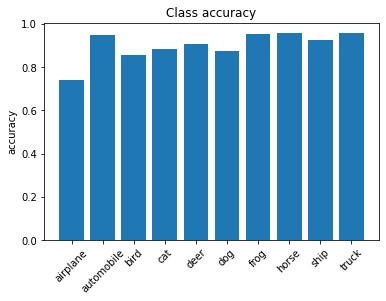

In [74]:
# analye class accuracy

model.eval()
count_correct = [0] * 10
count_total = [0] * 10

for img, lbl in testloader:
    out = model(img)
    _, indices = torch.max(out, 1)
    for i in range(len(indices)):
        count_correct[indices[i]] += (lbl[i] == indices[i]).item()
        count_total[indices[i]] += 1

accuracy = [c / t for c, t in zip(count_correct, count_total)]
fig, ax = plt.subplots()

ax.bar(np.arange(len(label_names)), accuracy)
ax.set_ylabel("accuracy")
ax.set_xticks(np.arange(len(label_names)), labels=label_names.values(), rotation=45)
ax.set_title("Class accuracy")

## 4.6 Convolutional Neural Networks (CNN) (Bonus)
If you want to build more sophisticated models to process images, CNNs are the specialized kind of neural network for processing data that has a known, grid-like topology. 

In what follows, you will get more familiar with this concept. In the __theoretical section__ we make you intuitively comfortable with the terms. Further in the __practical section__, you have to implement your own CNN like architecture (of course building/finetune youre CNNs around more sophisticated models like [ResNet](https://pytorch.org/vision/stable/models.html#id10) architectures is also possible). After you builded youre architecture, the task is to do the same steps like in the previous tasks (you can use youre already implemented functions!).

### 4.6.1 Theoretical Section

### Convolution layer
The name "convolutional neural network" indicates that the network uses a mathematical operation called convolution. Convolutional neural networks are simply neural networks that use convolution instead of general matrix multiplication in at least one of their layers. It expresses the amount of overlap of one function when it's shifted over another function. You can think of your eyes crossing over objects. Let's see it in action: 

![Alt Text](https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif)

<img src="https://render.githubusercontent.com/render/math?math=\displaystyle (f*g)(n)=\sum _{m=-\infty }^{\infty }f(m)g(n-m)">

As you can see in the above picture from left to right, we slide with the function $g$ against function $f$. In machine learning terms, the function $f$ would be a two-dimensional image and $g$ would be the kernel. In a CNN the opertion would look like this and is called a convolution layer:

<img src="https://stanford.edu/~shervine/teaching/cs-230/illustrations/convolution-layer-a.png?1c517e00cb8d709baf32fc3d39ebae67" alt="drawing" width="500"/>

The convolution layer uses filters/kernels that perform convolution operations as it is scanning the 2D image $I$. The hyperparameters include the filter size $F$ and stride $S$. The resulting output $O$ is called feature map/activation map. In the animation above you can see on the left the input image $I$, which gets scanned by the filter $F$ with a stride $S$ = 1. If you want, you can play interactively with [ConvPlayer](https://setosa.io/ev/image-kernels/) to get a more intuitive understanding about kernels/filters.

### Pooling layer 

<img src="https://camo.githubusercontent.com/6d0f5eac1c020be6f540df82378de7cc1570c1ba500b7e83ee6377e10a508ecc/68747470733a2f2f6d6c6e6f7465626f6f6b2e6769746875622e696f2f696d672f434e4e2f706f6f6c6669672e676966" alt="drawing" width="300"/>


The above animation shows max pooling, average pooling only takes the average value in the receptive (scanning) field. The pooling layer is a downsampling operation applied after a convolution layer. Particular, max and average pooling are special kinds of pooling where the maximum and average value is taken. 

### Fully Connected

<img src="https://stanford.edu/~shervine/teaching/cs-230/illustrations/fully-connected-ltr.png?32caf9e07c79d652faa292812579d063=50x20" alt="drawing" width="500"/>

Fully connected layer operates on a flattened input where each input is connected to all neurons. Fully connected layers are usually found towards the end of CNN architectures.

### Overview
<img src="https://miro.medium.com/max/1400/1*vkQ0hXDaQv57sALXAJquxA.jpeg" alt="drawing" width="500"/>

Putting it all together you get an CNN. A filter of size $F \times F$ applied to an input containing $C$ channels is a $F \times F \times C$ volume that performs convolutions on an input of size $I \times I \times C$ and produces an output feature map of $O \times O \times 1$. If you have $K$ filter/kernels of size $F \times F$ and apply the convolutional operation on input $I \times I \times C$ you will get feature map of $O \times O \times K$. This is the reason of the volumes in the above picture.

For a CNN to learn, it uses the same backpropagation algorithm. Although it may seem a little bit complicated how to do [gradient descent](https://de.wikipedia.org/wiki/Gradientenverfahren) on a CNN, it's really simple if you go through the operations step by step. If you want to have a more in-depth knowledge of how to train - from a mathematical viewpoint - a CNN, we recommend you to read this great [blogpost](https://pavisj.medium.com/convolutions-and-backpropagations-46026a8f5d2c). The really short explanation is $F_{new} = F_{old} - µ \frac{∂L}{∂F_{old}}$, so we update our filters/kernels based on the difference of the old filters $F_{old}$ and the derivate of the loss $L$ with respect to $F_{old}$.

### 4.6.2 Practical Section

In this section you have to implement your own CNN architecture. Please use the same dataset and do the same like in the previous tasks 4.3 to 4.5.

### Build Model
You can use this template to build your CNN or use another if you want. If you use a class to build your model, don't forget to first instantiate your model object after you have built it!

In [36]:
import torch.nn.functional as act


class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        # your code here (network layers)
        self.a1 = nn.Conv2d(3, 96, kernel_size=2)
        self.fc1 = nn.Linear(96 * 2 * 2, 432)
        self.fc2 = nn.Linear(432, 10)

    def forward(self, x):
        # your code here
        return x

### Train Loop
Here use your already implemented functions to train your model.

_Hint: copy and paste! ;)_

In [37]:
# your code here

### Visualize the training
Again, after you trained your model, plot (A) the training loss and the training accuracy and (B) the validation accuracy over the epochs.

In [38]:
# your code here

### Testing your Model
Now do the same steps like in task 4.5 for testing your CNN. If you want to see the performance of the CNN against the MLP, you can plot the training loss and the training accuracy on the same plot.

In [39]:
# your code here